# 파이토치로 구현하는 신경망

## 신경망 모델 구현하기

In [116]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plot
import torch.nn.functional as F

In [117]:
n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

In [118]:
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

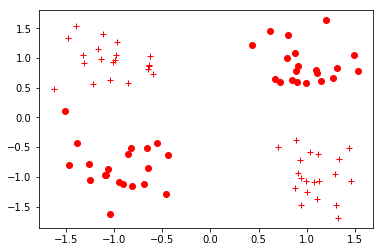

In [119]:
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plot.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plot.figure()
vis_data(x_train, y_train, c='r')
plot.show()

In [120]:
x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [121]:
class NeuralNet(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(NeuralNet, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, input_tensor):
            linear1 = self.linear_1(input_tensor)
            relu = self.relu(linear1)
            linear2 = self.linear_2(relu)
            output = self.sigmoid(linear2)
            return output

In [122]:
model = NeuralNet(2, 5)
learning_rate = 0.03
criterion = torch.nn.BCELoss()
epochs = 1000
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [123]:
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.6986902356147766


오차값이 0.73 이 나왔습니다. 이정도의 오차를 가진 모델은 사실상 분류하는 능력이 없다고 봐도 무방합니다.
자, 이제 드디어 인공신경망을 학습시켜 퍼포먼스를 향상시켜 보겠습니다.

In [124]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.7074869871139526
Train loss at 100 is 0.6346518993377686
Train loss at 200 is 0.5857511162757874
Train loss at 300 is 0.5401738882064819
Train loss at 400 is 0.4985213875770569
Train loss at 500 is 0.4663050174713135
Train loss at 600 is 0.4425601363182068
Train loss at 700 is 0.42557328939437866
Train loss at 800 is 0.4127162992954254
Train loss at 900 is 0.403198778629303


In [125]:
model.eval()
test_loss = criterion(model(x_test).squeeze(), y_test) 
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.37813660502433777


학습을 하기 전과 비교했을때 현저하게 줄어든 오차값을 확인 하실 수 있습니다.
지금까지 인공신경망을 구현하고 학습시켜 보았습니다.
이제 학습된 모델을 .pt 파일로 저장해 보겠습니다.

In [126]:
torch.save(model.state_dict(), './model.pt')

`save()` 를 실행하고 나면 학습된 신경망의 가중치를 내포하는 model.pt 라는 파일이 생성됩니다. 아래 코드처럼 새로운 신경망 객체에 model.pt 속의 가중치값을 입력시키는 것 또한 가능합니다.

In [127]:
new_model = NeuralNet(2, 5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [-1, 1]이 레이블 1을 가질 확률은 {}'.format(new_model(torch.FloatTensor([-1,1])).item()))

벡터 [-1, 1]이 레이블 1을 가질 확률은 0.46982789039611816
